# Final Project AM








(Due Date: Jan 11, 2024, class time)
discussion:
1. cal bandwidth不能很好地handle周期函数，需要手动扩大一些

### AM modulation Functions


In [194]:
# -*- coding: utf-8 -*-
"""
Created on Sat Dec  2 15:31:47 2023
Finished on Thu Dec  7 17:44:30 2023

@author: Suhao Wang
"""

import numpy as np
import math
    

# Define the message signal
def square_pulse(t,T1,dt,amplitude):
    return np.where((t >= T1-dt/2) & (t <= T1+dt/2), amplitude, 0)

# Generate the am signal with kf, Fc and mt
def generate_Am_signal(t, m_t, myka, myFc, Ac):
    am_signal = Ac*(1+myka*m_t)*np.cos(2*np.pi*myFc*t)  # am signal
    return am_signal

### Numerical Approach
#   func. find_bandwidth integarte to get the approximated band width
#   The func. will return the approximated bandwidth。
#   1. calculate bandwidth from Fc to left until 0 and from fc to right until "infinite"
#   2. make sure that fc>am+kf*Am
def calculate_bandwidth(f, Y, center, accuracy):
    # parameters
    step = (max(f) - min(f)) / len(f)
    n = len(Y)
    n_half = math.floor(n / 2)
    energy = np.zeros(n)
    df = f[1]-f[0]
    step = df
    ## df is 0.1, step 0.099995, but both seems good

    # total energy in positive axis
    energy[0] = step * math.pow(Y[0], 2)
    for i in range(1, n_half):
        energy[i] = energy[i - 1] + step * math.pow(Y[i], 2)

    # band_energy we need in positive axis
    total_energy = energy[n_half-1]
    band_energy = accuracy * total_energy
    
    # move
    center_index = (int)(center*1/step)
    energy[0] = step * math.pow(Y[center_index], 2)

    for i in range(1, n_half-center_index):
        energy[i] = energy[i - 1] + step * math.pow(Y[i+center_index], 2)
        if center_index-i>=0:
            energy[i] = energy[i] + step * math.pow(Y[center_index-i], 2)

        if (energy[i]>band_energy):
            if (center_index-i>=0):
                bandwidth = f[i+center_index]-f[center_index-i]
            else:
                bandwidth = f[i+center_index]
            break

    return round(bandwidth,3)


    
    


### AM demodulation functions


In [195]:
import numpy as np
from numpy.fft import fft, fftfreq,fftshift,ifft
import scipy.signal as signal


def demodulation(t, recv_signal,Fs,am_BT,m_bw,Fc,Ac,sampe_center=0):

    # band-pass filter
    # BPF的Bc意思是得到[fc-Bc/2,fc+Bc/2],h = 2Bcsinc(Bct)*cos(2pi*fc*t)
    Bc2 = am_BT
    h_hp = 2*Bc2*np.sinc(Bc2*(t-sampe_center))*np.cos(2*np.pi*Fc*t)
    x_t2 = np.convolve(recv_signal, h_hp,'same')/Fs

    # envelope
    # y(t) = Ac+Ac*ka*m(t)+ni(t)
    y_t2 = np.abs(signal.hilbert(x_t2))

    # remove dc component
    pass_t2 = y_t2-Ac  #归一化

    # low pass filter ## 书上这个图没画出来
    Bc = m_bw          
    h_lp = 2*Bc*np.sinc(2*Bc*(t-sampe_center))
    output_t2 = np.convolve(pass_t2,h_lp,'same')/Fs  #归一化


    return x_t2,y_t2,output_t2


![final project AM block diagram.PNG](<attachment:final project AM block diagram.PNG>)

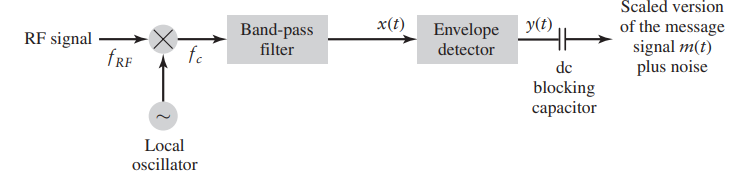

### Power functions

In [196]:
import numpy as np
from numpy.fft import fft, fftfreq
import scipy.signal as signal

def wrong_PSD(any_t,Fs,periodic=0):
    any_fbin = (fftfreq(len(any_t), d=1 / Fs))
    any_f = np.abs((fft(any_t)))
    if periodic==0:
        any_f = any_f/Fs
    else:
        any_f = any_f/len(any_f)

    psd = any_f**2/len(any_f)
    return any_fbin,psd


def PSD(any_t,Fs):
    # nperseg should be larger than Fs
    any_fbin, psd = signal.welch(any_t, fs=Fs, nperseg=2048, noverlap = int(2048*2/4),return_onesided=False)
    return any_fbin,psd


def average_power(any_t,Fs):
    # method 1, it's wrong if any_t is energy signal
    # f,Y = PSD(any_t,Fs)
    # step = (max(f)-min(f))/len(f)
    # result = np.sum(Y)*step

    # method 2, it's always true
    result = np.mean(np.square(any_t))
    return result

### plt function

In [197]:
import numpy as np
import matplotlib.pyplot as plt
def draw(t, signal_t, f, signal_f, signal_name,tmin=-2.5,tmax=2.5,amin=-250,amax=250):
    plt.figure(figsize=(16, 8))
    plt.subplot(2, 1, 1)
    plt.plot(t, signal_t)
    plt.title(signal_name)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.xlim(tmin,tmax)  
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(fftshift(f), np.abs(fftshift(signal_f)))
    plt.title(signal_name)
    plt.xlabel('frequency(Hz)')
    plt.ylabel('magnitude')
    plt.xlim(amin,amax)  
    plt.grid()

## 1. Single Call

### Global Parameters

In [198]:
# numerical values
T = 5
Fs = 2000                   # Sampling frequency (Hz)
t = np.arange(-T, T, 1/Fs)  # 1/Fs is the interval

### message signal
notice that ka*Am<1

In [199]:
# message signal
duration = 4  # rect(t/duration)
Am = 1        # the rectangular pulse amplitude is fixed to 1
m_t = square_pulse(t,0,duration,Am)
# m_t = Am*np.cos(2*np.pi*10*t)    ### 哈哈，我是替身

### modulation


In [200]:
# Define the parameters

Fc = 100       # Carrier frequency (Hz)
ka = 0.3       # Frequency sensitivity (Hz/Volt), 
Ac = 1       # carrier amplitude

# am_signal
am_t = generate_Am_signal(t, m_t, ka, Fc, Ac)

### calculate Bandwidth of Am signal and message signal

In [201]:
# meesage signal frequency domain
m_fbin = fftfreq(len(m_t), d=1 / Fs)
m_f = fft(m_t)/Fs   #非周期函数归一化要乘以1/fs
# am_signal frequency domain
am_fbin = fftfreq(len(am_t), d=1 / Fs)
am_f = fft(am_t)/Fs   #am 信号虽然是cos，但是仍然是非周期函数
# calculate bandwidth
m_bw = calculate_bandwidth(m_fbin,abs(m_f),0,0.999)
am_bw = calculate_bandwidth(am_fbin,abs(am_f),Fc,0.99999)  
# m_bw = 10.075       ### 哈哈，我是替身，必须用我，比计算值稍大一点，这里的bandwidth必须大到下面两种demodulation的output可以看到差别
# am_bw = 20.15     ### 哈哈，我是替身，必须用我，但是不能太大，否则theoretical值偏差大
print(m_bw)
print(am_bw)

18.1
159.4


### demodulation without noise

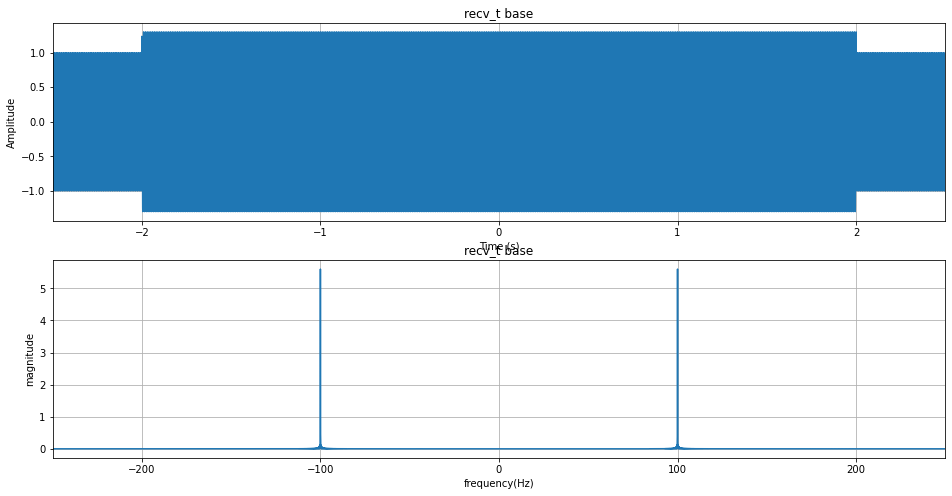

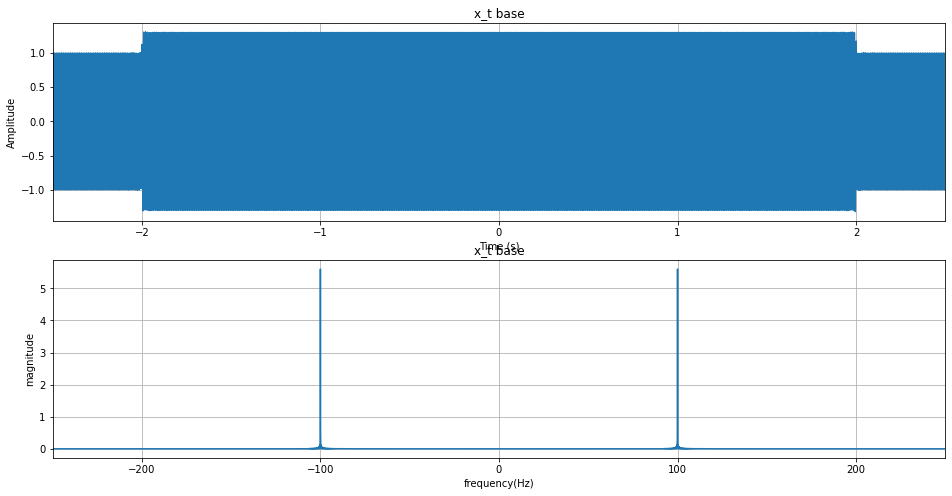

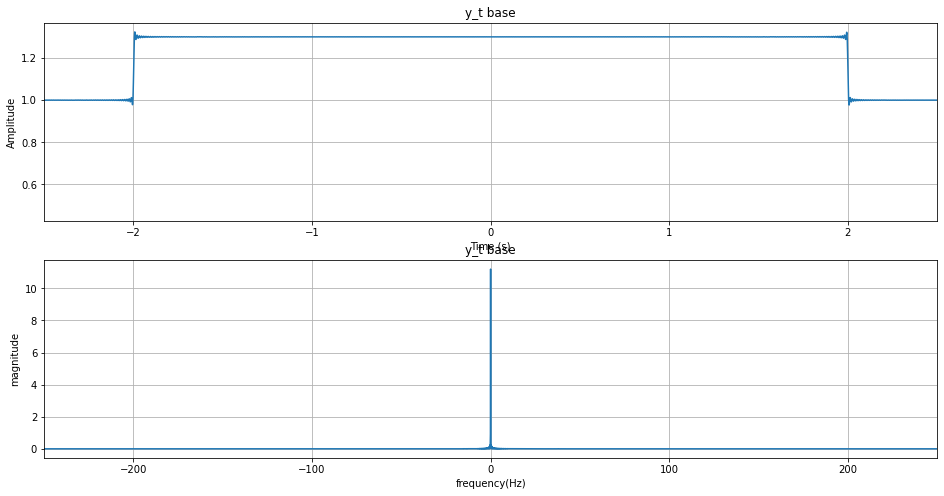

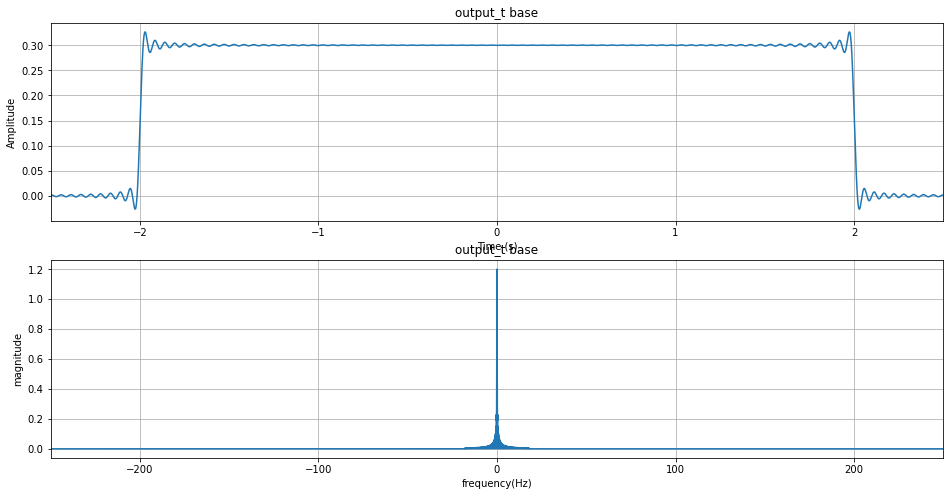

In [202]:

# add noise
recv_t2 = am_t

# demodulation
x_t2, y_t2, output_t2 = demodulation(t, recv_t2, Fs, am_bw, m_bw, Fc, Ac,0)

recv_f2 = fft(recv_t2)/Fs 
x_f2 = fft(x_t2)/Fs
y_f2 = fft(y_t2)/Fs
output_f2 = fft(output_t2)/Fs
draw(t,recv_t2,am_fbin,recv_f2,"recv_t base")
draw(t,x_t2,am_fbin,x_f2,"x_t base")
draw(t,y_t2,am_fbin,y_f2,"y_t base")
draw(t,output_t2,am_fbin,output_f2,"output_t base")



### Noisy signal demodulation

In [203]:
import numpy as np
from numpy.fft import fft, fftshift

# add noise
noise_size = 0.1
w_t = noise_size*np.random.randn(t.size)
recv_t = w_t + am_t


# demodulation
x_t, y_t, output_t = demodulation(t, recv_t, Fs, am_bw, m_bw, Fc, Ac, 0)


# get freq domain
recv_f = fft(recv_t)/Fs  
x_f = fft(x_t)/Fs
y_f = fft(y_t)/Fs
output_f = fft(output_t)/Fs


### plot figures

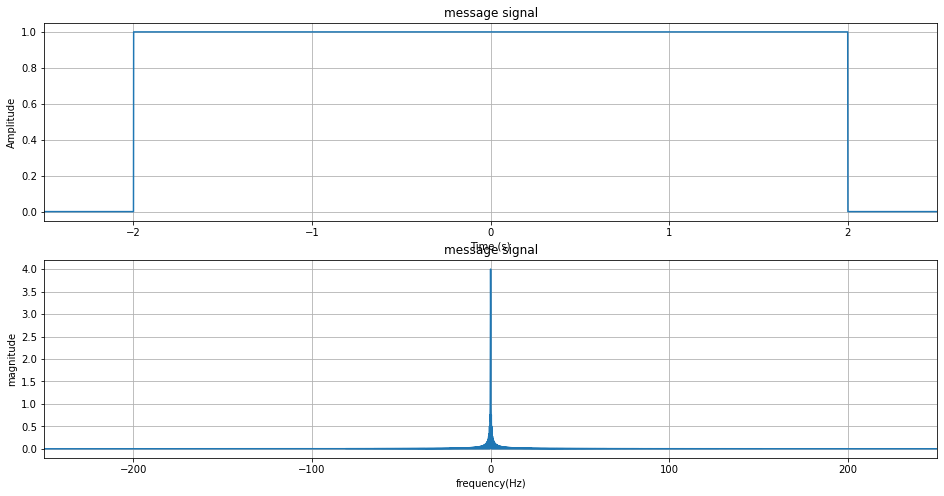

In [204]:
draw(t,m_t,m_fbin,m_f,"message signal")

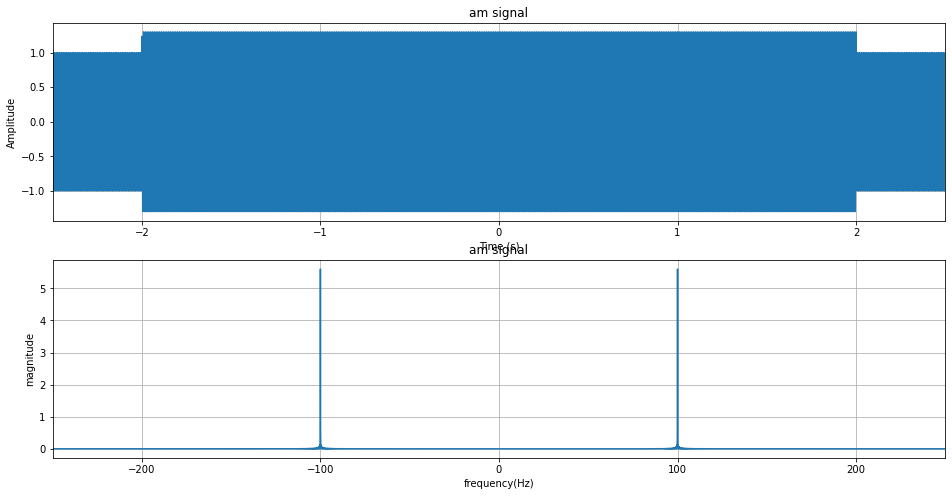

In [205]:
draw(t,am_t,am_fbin,am_f,"am signal")

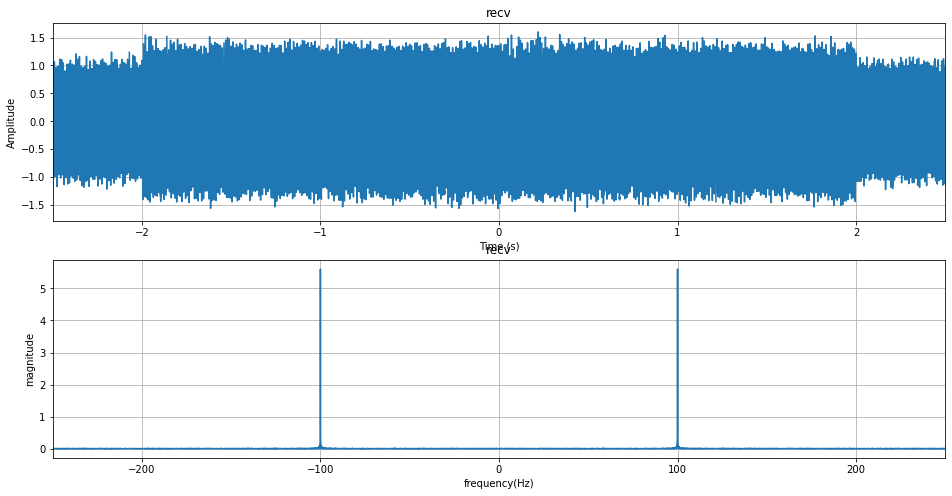

In [206]:
draw(t,recv_t,am_fbin,recv_f,'recv')

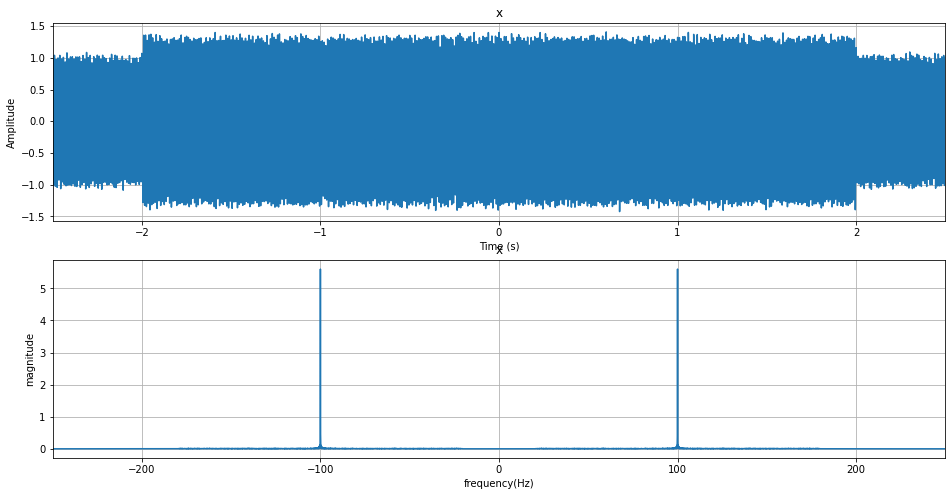

In [207]:

draw(t,x_t,am_fbin,x_f,"x")

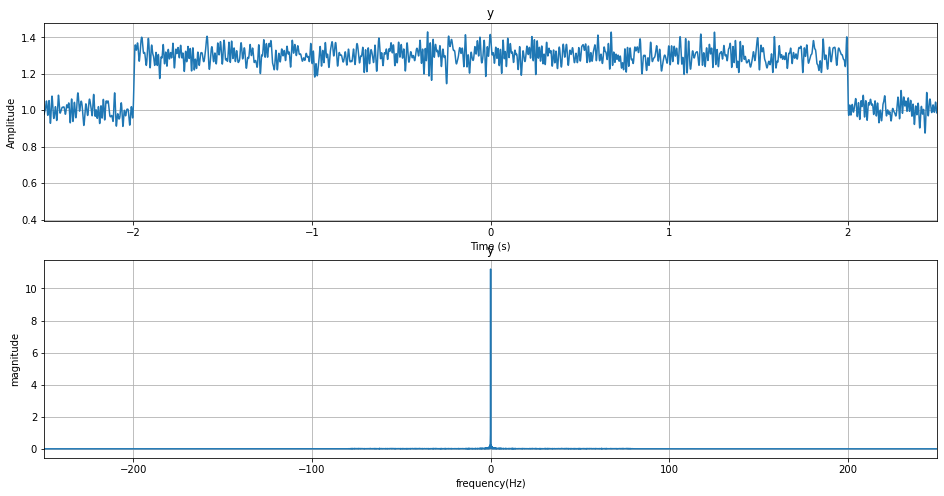

In [208]:

draw(t,y_t,am_fbin,y_f,"y")


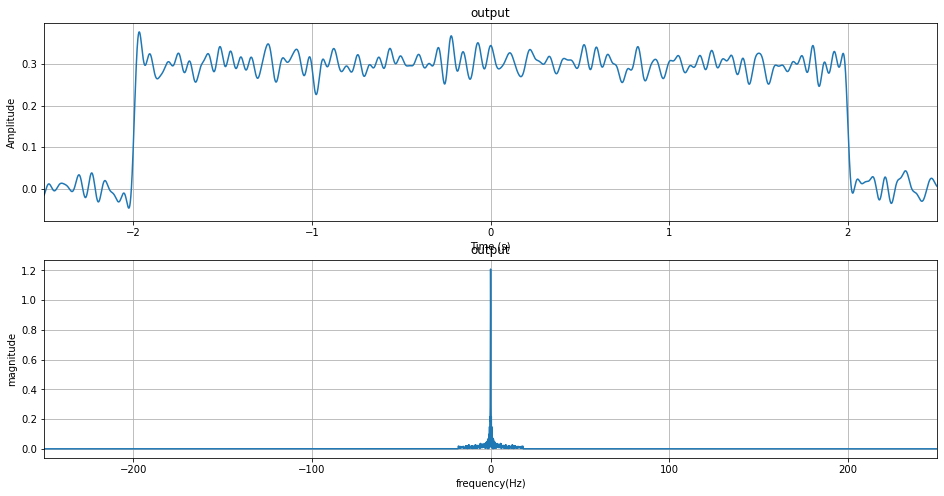

In [209]:

draw(t,output_t,am_fbin,output_f,"output")

### Pre SNR Comparision

In [210]:

# Simulation = average_power(x_t2,Fs)/ (average_power(x_t ,Fs) - (average_power(x_t2 ,Fs)))

Simulation = average_power(x_t2,Fs)/ (average_power(x_t - x_t2 ,Fs))

fbin, psd = PSD(w_t,Fs)
N0 = np.mean(psd)*2
BT = am_bw
P = average_power(m_t,Fs)
theoretical = Ac**2*(1+ka**2*P)/(2*N0*BT)

print("N0 is:",N0)
print("band-pass signal BT is:", BT)
print("pre_SNR is:",theoretical)
print("pre_SNR simulation is:",Simulation)

# print(average_power(am_t,Fs))
print(average_power(x_t2,Fs))
print(average_power(x_t,Fs))
print("p is:", P)



N0 is: 9.982831421421416e-06
band-pass signal BT is: 159.4
pre_SNR is: 325.52751684664
pre_SNR simulation is: 399.44352518596173
0.6380100559661831
0.6397813478333781
p is: 0.4


### post SNR Comparision

In [211]:
# Simulation = average_power(kf*m_t,Fs)/ (average_power(output_t,Fs) - average_power(kf*m_t,Fs)) 
# Simulation = average_power(kf*m_t,Fs)/ (average_power(output_t - kf*m_t,Fs))
## 这两个是错的
# SNR is smaller than the theoretic value，因为对于signal的power都使用了理论值
# 实际上，通过BPF和LPF都会对signal的power产生损耗
# That's why we need demodulation without noise first

## 这个也是错的
#Simulation = average_power(output_t2,Fs)/ (average_power(output_t,Fs) - average_power(output_t2,Fs)) 

Simulation = average_power(output_t2,Fs)/ (average_power(output_t - output_t2,Fs)) 

fbin, psd = PSD(w_t,Fs)
N0 = np.mean(psd)*2
W = m_bw
P = average_power(m_t,Fs)
theoretical = Ac**2*ka**2*P/(2*N0*W)

print("simulation is:",Simulation)
print("theoretical is:",theoretical)

print("W is:",W)
print("N0 is:",N0)

print(average_power(output_t2,Fs))
print(average_power(output_t,Fs))
print(P)





simulation is: 93.73665765907145
theoretical is: 99.61854469339997
W is: 18.1
N0 is: 9.982831421421416e-06
0.03597534271791911
0.036680504904983834
0.4


## 2. multiple calls

### All steps except noisy demodulation

In [212]:
# numerical values
T = 5
Fs = 2000                   # Sampling frequency (Hz)
t = np.arange(-T, T, 1/Fs)  # 1/Fs is the interval

# message signal
duration = 4  # rect(t/duration)
Am = 1        # the rectangular pulse amplitude is fixed to 1
m_t = square_pulse(t,0,duration,Am)
# m_t = Am*np.cos(2*np.pi*10*t)   ### 哈哈，我是替身

# am signal
Fc = 300       # Carrier frequency (Hz)
ka = 0.3      # Frequency sensitivity (Hz/Volt), 
Ac = 100       # carrier amplitude
am_t = generate_Am_signal(t, m_t, ka, Fc, Ac)

# calculate bandwidth
m_fbin = fftfreq(len(m_t), d=1 / Fs)
m_f = fft(m_t)/Fs   #非周期函数归一化要乘以1/fs 
am_fbin = fftfreq(len(am_t), d=1 / Fs)
am_f = fft(am_t)/Fs   #非周期函数归一化要乘以1/fs
m_bw = calculate_bandwidth(m_fbin,abs(m_f),0,0.999) 
am_bw = calculate_bandwidth(am_fbin,abs(am_f),Fc,0.999995)  
# m_bw = 10.075    ### 哈哈，我是替身,必须用我，bandwidth要大一点把function包括进来
# am_bw = 20.15       ### 哈哈，我是替身
print(m_bw)
print(am_bw)

# demodulation without noise
### add noise
recv_t2 = am_t
### demodulation
x_t2, y_t2, output_t2 = demodulation(t, recv_t2, Fs, am_bw, m_bw, Fc, Ac, sampe_center=0)

18.1
274.6


### plot comparision

In [213]:
# Define a function that takes the parameter as an input and performs the desired computation
# change noise size 
def compute_table_value(parameter):
    # Perform computations or calculations based on the parameter value
    
    # demodulation with noise
    ### add noise
    noise_size = parameter
    w_t = noise_size*np.random.randn(t.size)
    recv_t = w_t + am_t
    ### demodulation
    x_t, y_t, output_t = demodulation(t, recv_t, Fs, am_bw, m_bw, Fc, Ac, sampe_center=0)

    # simulation SNR
    pre_snr = average_power(x_t2,Fs)/ (average_power(x_t - x_t2 ,Fs))
    post_snr = average_power(output_t2,Fs)/ (average_power(output_t - output_t2,Fs)) 

    # theoretical SNR
    fbin, psd = PSD(w_t,Fs)
    N0 = np.mean(psd)*2
    BT = am_bw
    W = m_bw
    P = average_power(m_t,Fs)

    theoretical_pre = Ac**2*(1+ka**2*P)/(2*N0*BT)
    theoretical_post = Ac**2*ka**2*P/(2*N0*W)


    return 10*np.log10(pre_snr), 10*np.log10(post_snr), 10*np.log10(theoretical_pre), 10*np.log10(theoretical_post)

# Define the range of values for the parameter
parameter_values = range(150, 200)  # Example range, modify according to your needs

# Generate the table by iterating over the parameter values
for value in parameter_values:
    # Compute the corresponding table value for each parameter value
    pre,post,t_pre,t_post = compute_table_value(value)
    # Print the parameter value and the corresponding table value
    print(f"pre-SNR: {pre}, post-SNR: {post}, theoretical_pre_SNR:{t_pre}, theoretical_post_SNR:{t_post}")

pre-SNR: 0.30944116978593805, post-SNR: -6.56808197280148, theoretical_pre_SNR:-0.7358922641487663, theoretical_post_SNR:-3.5162452302525167
pre-SNR: 0.023029109611542222, post-SNR: -6.924829641252696, theoretical_pre_SNR:-0.8676963238894115, theoretical_post_SNR:-3.648049289993163
pre-SNR: 0.059278675516703294, post-SNR: -6.162126613359399, theoretical_pre_SNR:-0.9336934560105915, theoretical_post_SNR:-3.7140464221143428
pre-SNR: -0.10350948861135512, post-SNR: -6.542964888427773, theoretical_pre_SNR:-0.9236271827341115, theoretical_post_SNR:-3.7039801488378625
pre-SNR: 0.011957200336308201, post-SNR: -6.874870642546199, theoretical_pre_SNR:-1.0156702729197091, theoretical_post_SNR:-3.79602323902346
pre-SNR: -0.30003786270201177, post-SNR: -7.010020255118288, theoretical_pre_SNR:-1.0947530685140323, theoretical_post_SNR:-3.875106034617784
pre-SNR: -0.29375509357810975, post-SNR: -6.739225952709496, theoretical_pre_SNR:-1.1128209451425128, theoretical_post_SNR:-3.893173911246264
pre-SN

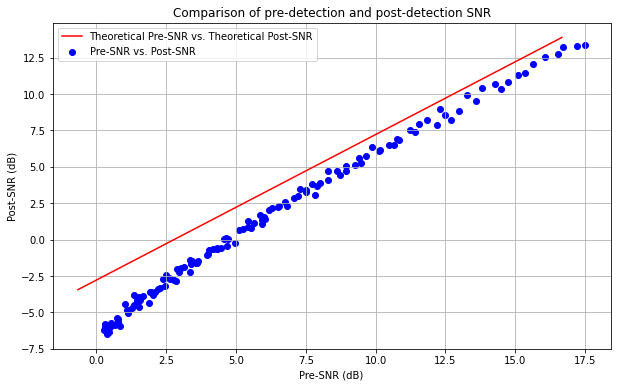

In [214]:
import matplotlib.pyplot as plt

# Define the range of values for the parameter
parameter_values = range(20,150)  # Example range, modify according to your needs

# Initialize empty lists to store the computed table values
pre_snr_values = []
post_snr_values = []
theoretical_pre_snr_values = []
theoretical_post_snr_values = []

# Iterate over the parameter values and compute the table values
for value in parameter_values:
    pre, post, t_pre, t_post = compute_table_value(value)
    pre_snr_values.append(pre)
    post_snr_values.append(post)
    theoretical_pre_snr_values.append(t_pre)
    theoretical_post_snr_values.append(t_post)

# Create a figure with pre-SNR vs. post-SNR and theoretical pre-SNR vs. theoretical post-SNR
# fig, ax = plt.subplots(figsize=(16, 8))
# ax.scatter(pre_snr_values, post_snr_values, label='Pre-SNR vs. Post-SNR', color='blue')
# ax.plot(theoretical_pre_snr_values, theoretical_post_snr_values, label='Theoretical Pre-SNR vs. Theoretical Post-SNR', color='red')
# ax.set_xlabel('Pre-SNR (dB)')
# ax.set_ylabel('Post-SNR (dB)')
# ax.set_title('SNR Comparison')
# ax.legend()

plt.figure(figsize=(10, 6))
plt.scatter(pre_snr_values, post_snr_values, label='Pre-SNR vs. Post-SNR', color='blue')
plt.plot(theoretical_pre_snr_values, theoretical_post_snr_values, label='Theoretical Pre-SNR vs. Theoretical Post-SNR', color='red')
plt.xlabel('Pre-SNR (dB)')
plt.ylabel('Post-SNR (dB)')
plt.title('Comparison of pre-detection and post-detection SNR')
# plt.xticks(np.arange(8,32,2))
plt.grid()
plt.legend()

# Show the figure
plt.show()

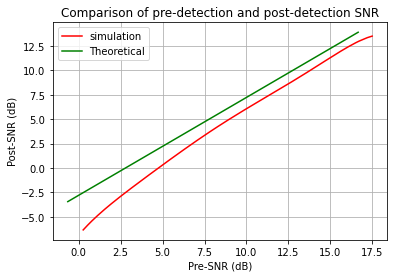

In [215]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Perform polynomial regression to fit a curve to the scatter plot
degree = 6  # Degree of the polynomial
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(np.array(pre_snr_values).reshape(-1, 1))
reg = LinearRegression().fit(X_poly, np.array(post_snr_values).reshape(-1, 1))
fit_line = reg.predict(X_poly)

# Sort the pre-SNR values and corresponding fitted line for smoother visualization
sorted_indices = np.argsort(pre_snr_values)
pre_snr_values_sorted = np.array(pre_snr_values)[sorted_indices]
fit_line_sorted = np.array(fit_line)[sorted_indices]

# Create the scatter plot with pre-SNR on the x-axis and post-SNR on the y-axis, along with the fitted curve
plt.figure()
# plt.scatter(pre_snr_values, post_snr_values, label='Data Points')
plt.plot(pre_snr_values_sorted, fit_line_sorted, color='red', label='simulation')
plt.plot(theoretical_pre_snr_values, theoretical_post_snr_values, label='Theoretical', color='green')
plt.xlabel('Pre-SNR (dB)')
plt.ylabel('Post-SNR (dB)')
plt.title('Comparison of pre-detection and post-detection SNR')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()